In [0]:
pip install category_encoders

In [0]:
pip install eli5

     |████████████████████████████████| 112kB 2.8MB/s 


In [0]:
import eli5
from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.

Using TensorFlow backend.


In [0]:
import pandas as pd 
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression 
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
import seaborn as sns
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
youtube=pd.read_csv('YouTube.csv')

In [0]:
def data_wrangle(X):
  X=X.copy()
  #columns to be deleted(high cardinality)
  deleted=['web-scraper-order','web-scraper-start-url','userID',
           'userID-href','YouTube_Link','YouTube_Link-href',
           'TwitterHandle','TwitterHandle-href','InstagramHandle',
           'InstagramHandle-href']

  X=X.drop(columns=deleted)
  #split columns from ranges into seperate columns
  X[['monthly_lower_range','monthly_higher_range']]=X.MonthlyEarnings.str.split("-",expand=True)
  X[['yearly_lower_range','yearly_higher_range']]=X.YearlyEarnings.str.split("-", expand=True)

  #delete original columns
  wages=['MonthlyEarnings','YearlyEarnings']
  X=X.drop(columns=wages)

  col_with_dollar=['monthly_lower_range','monthly_higher_range',
                   'yearly_lower_range','yearly_higher_range']
  for col in col_with_dollar:
      X[col] = X[col].str.replace('$', '')

  col_with_k=['monthly_lower_range','monthly_higher_range',
              'yearly_lower_range','yearly_higher_range']
  for col in col_with_k:
    X[col]=X[col].str.replace('K','00')

  col_with_m=['monthly_lower_range','monthly_higher_range',
              'yearly_lower_range','yearly_higher_range']
  for col in col_with_m:
    X[col]=X[col].str.replace('M','00000')

  col_with_decimal=['monthly_lower_range','monthly_higher_range',
                    'yearly_lower_range','yearly_higher_range']
  for col in col_with_decimal:
    X[col]=X[col].str.replace('.','')  

  col_convert=['monthly_lower_range','monthly_higher_range',
               'yearly_lower_range','yearly_higher_range']
  for col in col_convert:
    X[col]=X[col].astype(float)*1.08

  col_nan=['monthly_lower_range','monthly_higher_range',
               'yearly_lower_range','yearly_higher_range']  
  for col in col_nan:
    X[col]=X[col].replace(np.NaN,0)

  X['yearly_average']=X.yearly_lower_range + X.yearly_higher_range/ 2
  X['monthly_average']=X.yearly_average/12

  X=X[X['monthly_lower_range']>1000]
  X=X[X['yearly_lower_range']>0]



  top10=X['channeltype'].value_counts()[:10].index
  X.loc[~X['channeltype'].isin(top10),'channeltype']=='Other'

  X['usercreated']=pd.to_datetime(X['usercreated'])
  X['yearcreated']=X['usercreated'].dt.year
  X=X.drop(columns='usercreated')
  
  X=X.set_index(keys='name')



  return X

In [0]:
youtube=data_wrangle(youtube)

In [0]:
train=youtube.copy()
train, test = train_test_split(train, train_size=.80, test_size=.20, 
                               random_state=42)

In [0]:
train, val = train_test_split(train, test_size=.20, 
                              random_state=42)

In [0]:
train.shape, val.shape, test.shape

((1868, 14), (468, 14), (585, 14))

In [0]:
leakage=['monthly_lower_range','monthly_higher_range','yearly_lower_range','yearly_average','yearly_higher_range']
train=train.drop(columns=leakage)
val=val.drop(columns=leakage)
test=test.drop(columns=leakage)

In [0]:
target='monthly_average'
features= train.drop(columns=[target]).columns
# print(features)
x_train=train[features]
y_train=train[target]
# y_train
x_val=val[features]
y_val=val[target]
#x_test
x_test=test[features]
y_test=test[target]


In [0]:
#test needs to always be first
def accuracy_test(x,y):
  errors = abs(y - x)
  accuracy=errors/x
  accuracy_mean=np.mean(100 * (errors / x))

  return(accuracy_mean)


In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    RandomForestRegressor(n_estimators=709, max_depth=1163, criterion='mae', min_samples_leaf=4)
)

pipeline.fit(x_train,y_train)
y_pred=pipeline.predict(x_val)

accuracy_test(y_val,y_pred)

63.221215198309345

In [0]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'),
    StandardScaler() 
)

x_train_transformed = transformers.fit_transform(x_train)
x_val_transformed = transformers.transform(x_val)

model = RandomForestRegressor(n_estimators=709, max_depth=1163,
                              random_state=42, criterion='mae', n_jobs=-1,
                              min_samples_leaf=4)
model.fit(x_train_transformed, y_train)


permuter = PermutationImportance(
    model,
    n_iter=5,
    random_state=42
)

permuter.fit(x_val_transformed, y_val)

feature_names = x_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
1.0062 ± 0.1089,grade
0.0977 ± 0.0305,videoviews
0.0174 ± 0.0150,subscribers
0.0118 ± 0.0073,country
0.0043 ± 0.0040,channeltype
0.0022 ± 0.0132,uploads
0.0007 ± 0.0075,yearcreated
-0.0027 ± 0.0145,years_around


In [0]:
x_train=x_train.drop(columns='years_around')
x_val=x_val.drop(columns='years_around')
x_test=x_test.drop(columns='years_around')

In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    RandomForestRegressor(n_estimators=709, max_depth=1163, criterion='mae', min_samples_leaf=4)
)

pipeline.fit(x_train,y_train)
y_pred=pipeline.predict(x_val)

accuracy_test(y_val,y_pred)

63.159489828253854

In [0]:
youtube2=pd.read_csv('YouTube2.csv')

In [0]:
youtube2=data_wrangle(youtube2)

In [0]:
train=youtube2.copy()
train, test = train_test_split(train, train_size=.80, test_size=.20, 
                               random_state=42)

In [0]:
train, val = train_test_split(train, test_size=.20, 
                              random_state=42)

In [0]:
leakage=['monthly_lower_range','years_around','monthly_higher_range',
         'yearly_lower_range','yearly_average','yearly_higher_range']
train=train.drop(columns=leakage)
val=val.drop(columns=leakage)
test=test.drop(columns=leakage)

In [0]:
target='monthly_average'
features= train.drop(columns=[target]).columns
# print(features)
x_train=train[features]
y_train=train[target]
# y_train
x_val=val[features]
y_val=val[target]
#x_test
x_test=test[features]
y_test=test[target]


In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    RandomForestRegressor(n_estimators=709, max_depth=1163, criterion='mae', min_samples_leaf=4)
)

pipeline.fit(x_train,y_train)
y_pred=pipeline.predict(x_val)

accuracy_test(y_val,y_pred)

57.861301688299065

In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    RandomForestRegressor(n_estimators=709, max_depth=1163, criterion='mae', 
                          min_samples_leaf=4, n_jobs=-1, random_state=42)
)

pipeline.fit(x_train,y_train)
y_pred=pipeline.predict(x_val)

accuracy_test(y_val,y_pred)

53.87948822877065

In [0]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'),
    StandardScaler() 
)

x_train_transformed = transformers.fit_transform(x_train)
x_val_transformed = transformers.transform(x_val)

model = RandomForestRegressor(n_estimators=709, max_depth=1163,
                              random_state=42, criterion='mae', n_jobs=-1,
                              min_samples_leaf=4)
model.fit(x_train_transformed, y_train)


permuter = PermutationImportance(
    model,
    n_iter=5,
    random_state=42
)

permuter.fit(x_val_transformed, y_val)

feature_names = x_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.9329 ± 0.1437,grade
0.0531 ± 0.0178,videoviews
0.0113 ± 0.0089,uploads
0.0096 ± 0.0329,yearcreated
0.0070 ± 0.0115,country
0.0051 ± 0.0166,subscribers
0.0043 ± 0.0042,channeltype


In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestRegressor(n_estimators=709, max_depth=1163, criterion='mae', 
                          min_samples_leaf=4, n_jobs=-1, random_state=42)
)

pipeline.fit(x_train,y_train)
y_pred=pipeline.predict(x_val)

accuracy_test(y_val,y_pred)

53.870488848654446

In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestRegressor(n_estimators=700, max_depth=1163, criterion='mae', 
                          min_samples_leaf=4, n_jobs=-1, random_state=42)
)

pipeline.fit(x_train,y_train)
y_pred=pipeline.predict(x_val)

accuracy_test(y_val,y_pred)

53.85894388173701

In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestRegressor(n_estimators=700, max_depth=1163, criterion='mae', 
                          min_samples_leaf=4, n_jobs=-1, random_state=42)
)

pipeline.fit(x_train,y_train)
y_pred_test=pipeline.predict(x_test)

accuracy_test(y_test,y_pred_test)

51.69512620641655

In [0]:
y_pred_train=pipeline.predict(x_train)

accuracy_test(y_test,y_pred_test)

51.69512620641655

In [0]:
predictions_val = pd.concat([x_val,y_val],axis=1)
predictions_val['predictions'] = y_pred
predictions_test= pd.concat([x_test,y_test],axis=1)
predictions_test['predictions']=y_pred_test
predictions_train=pd.concat([x_train,y_train],axis=1)
predictions_train['predictions']=y_pred_train
predictions=pd.concat([predictions_val,predictions_test, predictions_train])

In [0]:
predictions.head()

,uploads,subscribers,videoviews,country,channeltype,grade,yearcreated,monthly_average,predictions
name,,,,,,,,,
Reaction Time,1378,12181503,3580937652,US,Entertainment,A,2015,192366.0,340325.222143
Alan Walker,173,22328931,5981936573,Other,Music,A,2012,379602.0,335795.798571
SelenaGomezVEVO,127,15472807,7029167647,US,Music,A-,2009,136863.0,129423.336429
BreakMan,231,4273094,601902717,ES,Entertainment,B,2016,42736.5,19511.173929
Busy Beavers - Kids Learn ABCs 123s & More,647,2592635,2481784203,Other,Education,B,2007,16933.5,16249.194643


In [140]:
abs(predictions.monthly_average-predictions.predictions).mean()

23965.307380539813

In [0]:
drop=['uploads','subscribers','videoviews','country','channeltype']
predictions=predictions.drop(columns=drop)

In [0]:
graph=predictions.sample(n=15, random_state=42)

In [0]:
graph.head(15)

,grade,yearcreated,monthly_average,predictions
name,,,,
Desi Nuskhe,B,2016,10755.0,13031.173929
SACCONEJOLYs,B,2009,9180.0,15264.466071
Los Juguetes Son Divertidos,A,2015,156726.0,207575.421429
Alhayah Series TV,A-,2013,116577.0,119675.828571
CiccioGamer89,B,2012,24174.0,19362.387857
LazarBeam,A,2015,521694.0,391471.939286
Sing Music Channel,A-,2011,146817.0,131311.857857
Cong TV,B,2008,14652.0,14248.915714
FV FAMILY,A,2018,475749.0,224458.135714


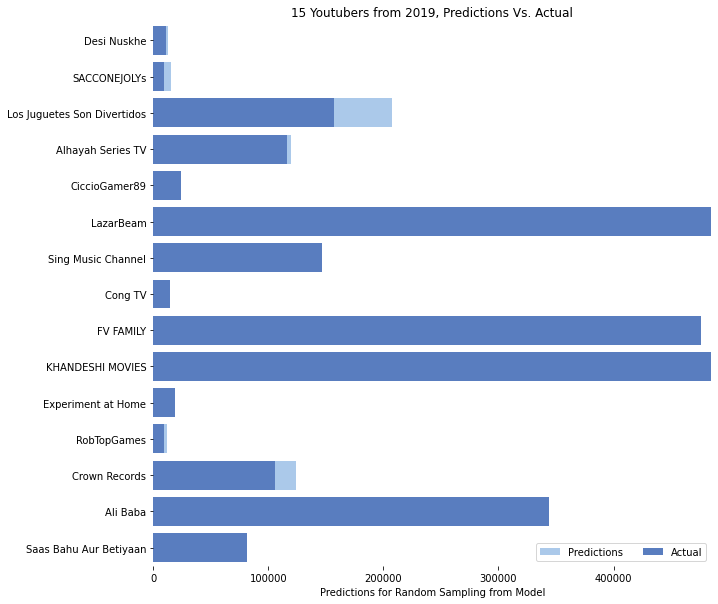

In [0]:
f, ax = plt.subplots(figsize=[10,10])

#plot the predictions
sns.set_color_codes("pastel")
sns.barplot(x="predictions", y=graph.index, data=graph,
            label="Predictions", color="b")

# Plot the actual
sns.set_color_codes("muted")
sns.barplot(x="monthly_average", y=graph.index, data=graph,
            label="Actual", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0,485000), ylabel="",
       xlabel="Predictions for Random Sampling from Model",
       title='15 Youtubers from 2019, Predictions Vs. Actual')
sns.despine(left=True, bottom=True)

plt.savefig("predsvsacts.png")

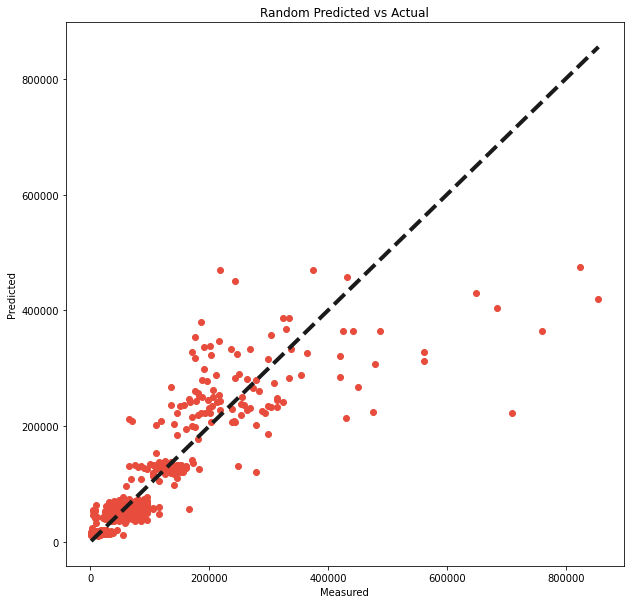

In [125]:
fig, ax = plt.subplots(figsize=[10,10])
y=predictions_test.monthly_average
predicted=predictions_test.predictions

ax.scatter(y, predicted, c='#e74c3c') 
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set(title='Random Predicted vs Actual')
fig.savefig("predvsactline.png")
plt.show()


ConversionError: ignored

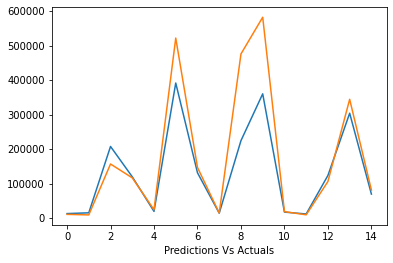

In [138]:
names=graph.name
plt.plot(graph.predictions)
plt.plot(graph.monthly_average)
plt.xlabel('Predictions Vs Actuals')
plt.xticks(ticks=names,labels=None)

plt.savefig("predsvsactsboth.png")

In [121]:
features=['grade','subscribers']
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], # First feature on x axis
    index=features[1]    # Next feature on y axis
)[::-1]  # Reverse the index order so y axis is ascending

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
plt.figure(figsize=(10,8))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Partial Dependence of Yearly Highend Salary Range on Youtube based on ')
pdp.plt.savefig('subscribersandgrade.png', dpi=200)
plt.show()

NameError: ignored